# **Employee Attrition Prediction (EAP)**

The client (anonymized) is an automotive company known for its high-performance culture but currently struggling with higher-than-average employee turnover. Using a dataset of employee metrics, my goal is to build a machine learning model that predicts whether an employee will leave the company (churn = 1) or stay (churn = 0).

This code is 4 main parts:

1. Data Exploration and Visualization
2. Feature Engineering and Modeling
3. Evaluation and Interpretation
4. Conclusion and Recommendations

This question is from a capstone assignment I worked on previously. While I completed it successfully, I didn't fully understand the code I wrote—much of it was pieced together from various online sources without grasping the underlying concepts. I decided to redo this project from scratch to: 1) become more proficient in Python, 2) learn to properly implement classification algorithms, and 3) understand the mathematical foundations of these algorithms through visualization and experimentation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    roc_auc_score, roc_curve
)
from sklearn.tree import plot_tree

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

In [2]:
df_original = pd.read_csv("HR_capstone_dataset.csv")
print(f"  Shape: {df_original.shape}")
print(f"  Rows: {df_original.shape[0]:,}, Columns: {df_original.shape[1]}")

  Shape: (14999, 10)
  Rows: 14,999, Columns: 10


## Step 1. Data Exploration and Visualization

In [3]:
df_original.info()
print(df_original.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
       satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.

### Rename columns

In [4]:
column_mapping = {
    'Work_accident': 'work_accident',
    'average_montly_hours': 'average_monthly_hours',
    'time_spend_company': 'tenure',
    'Department': 'department'
}

df_renamed = df_original.rename(columns=column_mapping)

### Check duplicates

In [5]:
num_duplicates = df_renamed.duplicated().sum()
print(f"  Duplicates found: {num_duplicates:,}")

if num_duplicates > 0:
    df_clean = df_renamed.drop_duplicates(keep='first')
    print(f"✓ Removed {num_duplicates:,} duplicate rows")
    print(f"  New shape: {df_clean.shape}")
else:
    df_clean = df_renamed.copy()
    print("✓ No duplicates to remove")

  Duplicates found: 3,008
✓ Removed 3,008 duplicate rows
  New shape: (11991, 10)


### Check outliers

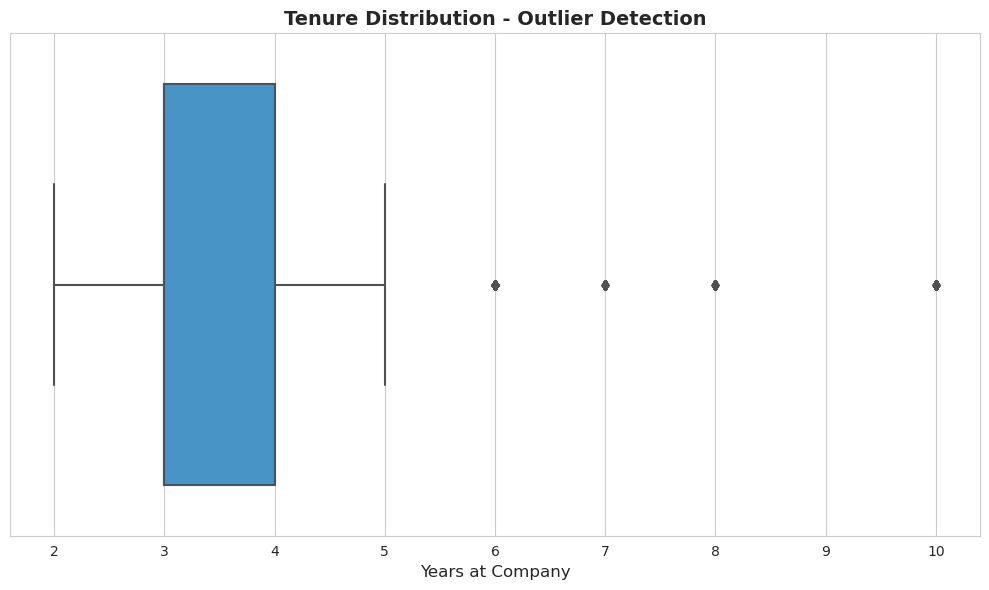

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_clean, x='tenure', color='#3498db', ax=ax)
ax.set_title('Tenure Distribution - Outlier Detection', fontsize=14, fontweight='bold')
ax.set_xlabel('Years at Company', fontsize=12)
plt.tight_layout()
plt.show()

In [7]:
Q1 = df_clean['tenure'].quantile(0.25)
Q3 = df_clean['tenure'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_clean[(df_clean['tenure'] < lower_bound) | (df_clean['tenure'] > upper_bound)]

print(f"  Q1 (25th percentile): {Q1}")
print(f"  Q3 (75th percentile): {Q3}")
print(f"  IQR: {IQR}")
print(f"  Lower bound: {lower_bound}")
print(f"  Upper bound: {upper_bound}")
print(f"  Number of outliers: {len(outliers):,}")

  Q1 (25th percentile): 3.0
  Q3 (75th percentile): 4.0
  IQR: 1.0
  Lower bound: 1.5
  Upper bound: 5.5
  Number of outliers: 824


### Target Variable Analysis

In [8]:
print("\nAbsolute counts:")
print(df_clean['left'].value_counts())

print("\nProportions:")
proportions = df_clean['left'].value_counts(normalize=True)
print(proportions)

churn_rate = proportions[1]
retention_rate = proportions[0]


Absolute counts:
0    10000
1     1991
Name: left, dtype: int64

Proportions:
0    0.833959
1    0.166041
Name: left, dtype: float64


The dataset is imbalanced, with approximately 17% of employees having left the company. This is a crucial finding that will influence how I evaluate my model later on. Now, I will create some visualizations to dig deeper.

### Data visualizations

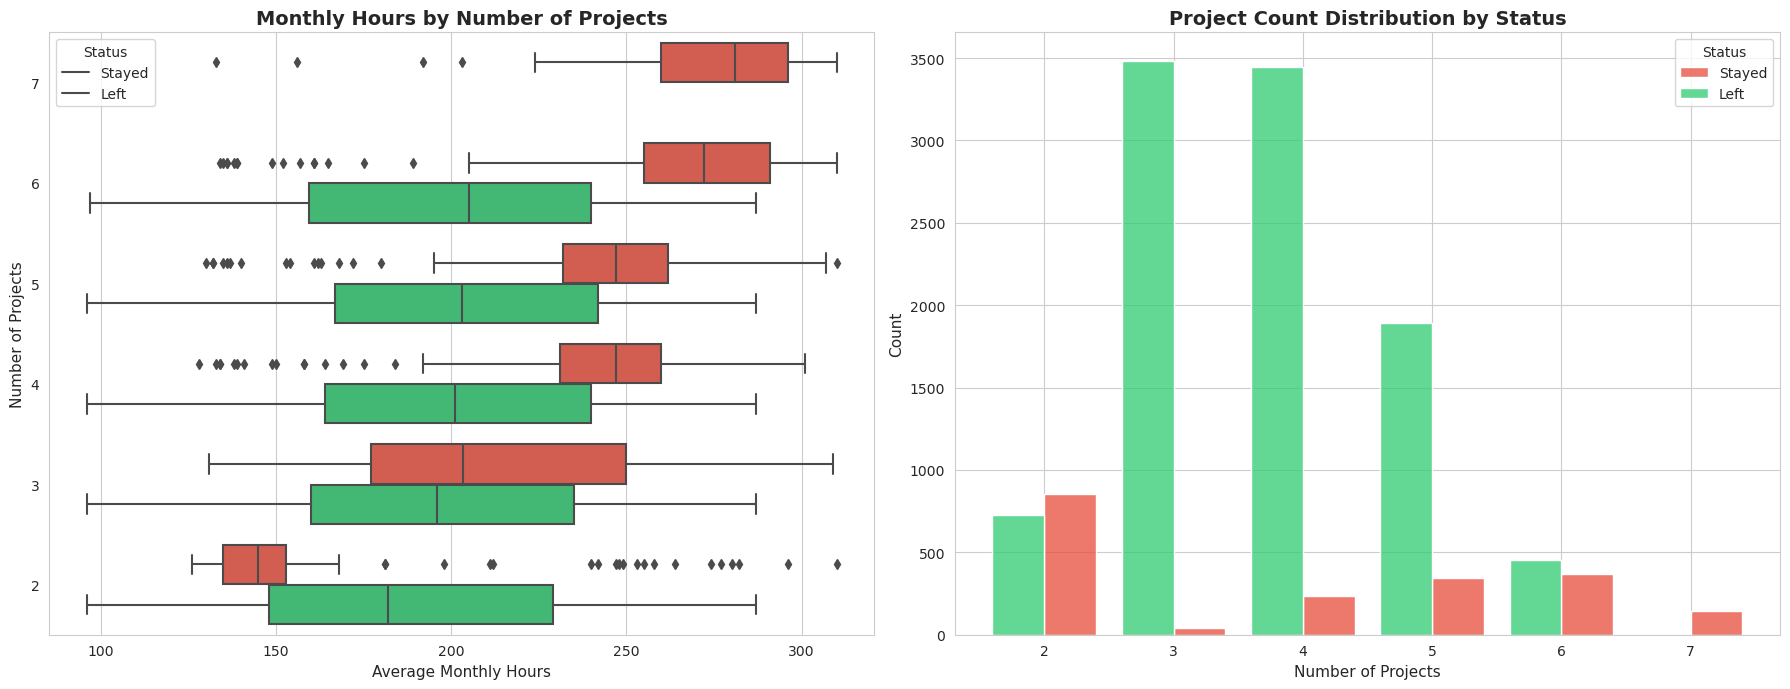

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.boxplot(
    data=df_clean,
    x='average_monthly_hours',
    y='number_project',
    hue='left',
    orient='h',
    ax=axes[0],
    palette=['#2ecc71', '#e74c3c']
)
axes[0].invert_yaxis()
axes[0].set_title('Monthly Hours by Number of Projects', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Average Monthly Hours', fontsize=11)
axes[0].set_ylabel('Number of Projects', fontsize=11)
axes[0].legend(title='Status', labels=['Stayed', 'Left'])

sns.histplot(
    data=df_clean,
    x='number_project',
    hue='left',
    multiple='dodge',
    shrink=0.8,
    ax=axes[1],
    palette=['#2ecc71', '#e74c3c'],
    discrete=True
)
axes[1].set_title('Project Count Distribution by Status', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Projects', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].legend(title='Status', labels=['Stayed', 'Left'])

plt.tight_layout()
plt.show()

1. Two distinct leaver profiles emerged:
   - Group A: Employees who worked significantly fewer hours than their peers, possibly indicating disengagement or impending termination.
   - Group B: High-performers who worked significantly more hours, suggesting burnout.
2. Employees working on 6 or 7 projects show an extremely high churn rate. All employees with 7 projects left the company.
3. The standard 40-hour work week averages to ~167 hours/month. The data shows that nearly every employee group, including those who stayed, works considerably more than this baseline, indicating a potential company-wide culture of overwork.

In [10]:
employees_7_projects = df_clean[df_clean['number_project'] == 7]['left'].value_counts()
print(f"  Employees with 7 projects who left = {employees_7_projects.get(1, 0)}")

  Employees with 7 projects who left = 145


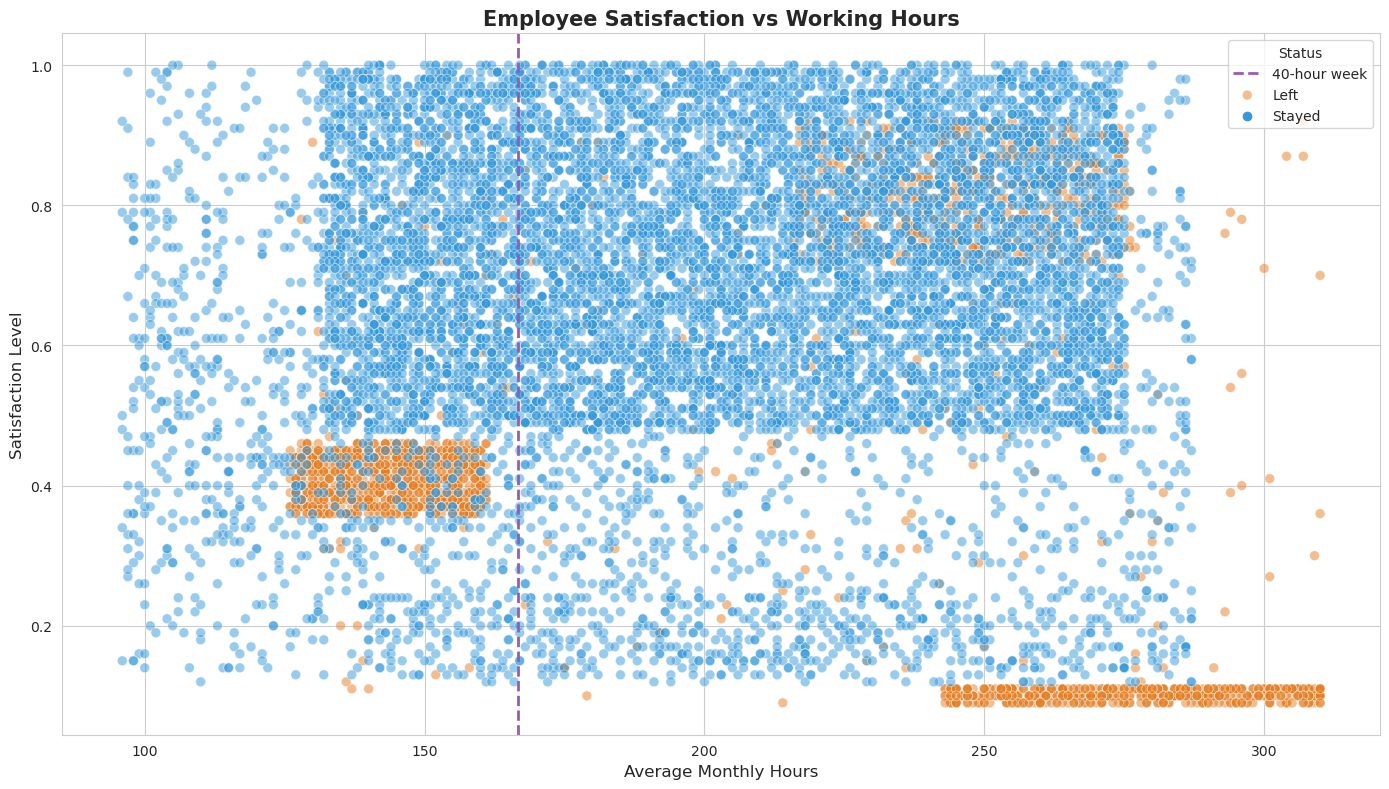

In [11]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.scatterplot(
    data=df_clean,
    x='average_monthly_hours',
    y='satisfaction_level',
    hue='left',
    alpha=0.5,
    palette=['#3498db', '#e67e22'],
    s=50,
    ax=ax
)
ax.axvline(x=166.67, color='#9b59b6', linestyle='--', linewidth=2, label='40-hour week (~167 hrs/mo)')
ax.set_title('Employee Satisfaction vs Working Hours', fontsize=15, fontweight='bold')
ax.set_xlabel('Average Monthly Hours', fontsize=12)
ax.set_ylabel('Satisfaction Level', fontsize=12)
ax.legend(title='Status', labels=['40-hour week', 'Left', 'Stayed'])
plt.tight_layout()
plt.show()

The scatterplot reveals three distinct groups of employees based on their work hours and satisfaction levels:
- Overworked & unhappy (Leavers): A large group worked an unsustainable 240-315 hours per month and had low satisfaction levels (< 0.2).
- Moderately satisfied (Leavers): A second group of leavers who worked normal hours but whose satisfaction was mediocre, hovering around 0.4.
- Content & engaged (Stayers): The majority of employees who stayed with the company had high satisfaction levels (0.7-0.9) while working moderately long hours (210-280 per month).

The distinct, non-random clustering of data points is highly unusual for real-world employee data. This pattern strongly suggests that the dataset is likely synthetic or has been artificially manipulated, which is an important consideration for the final model. 

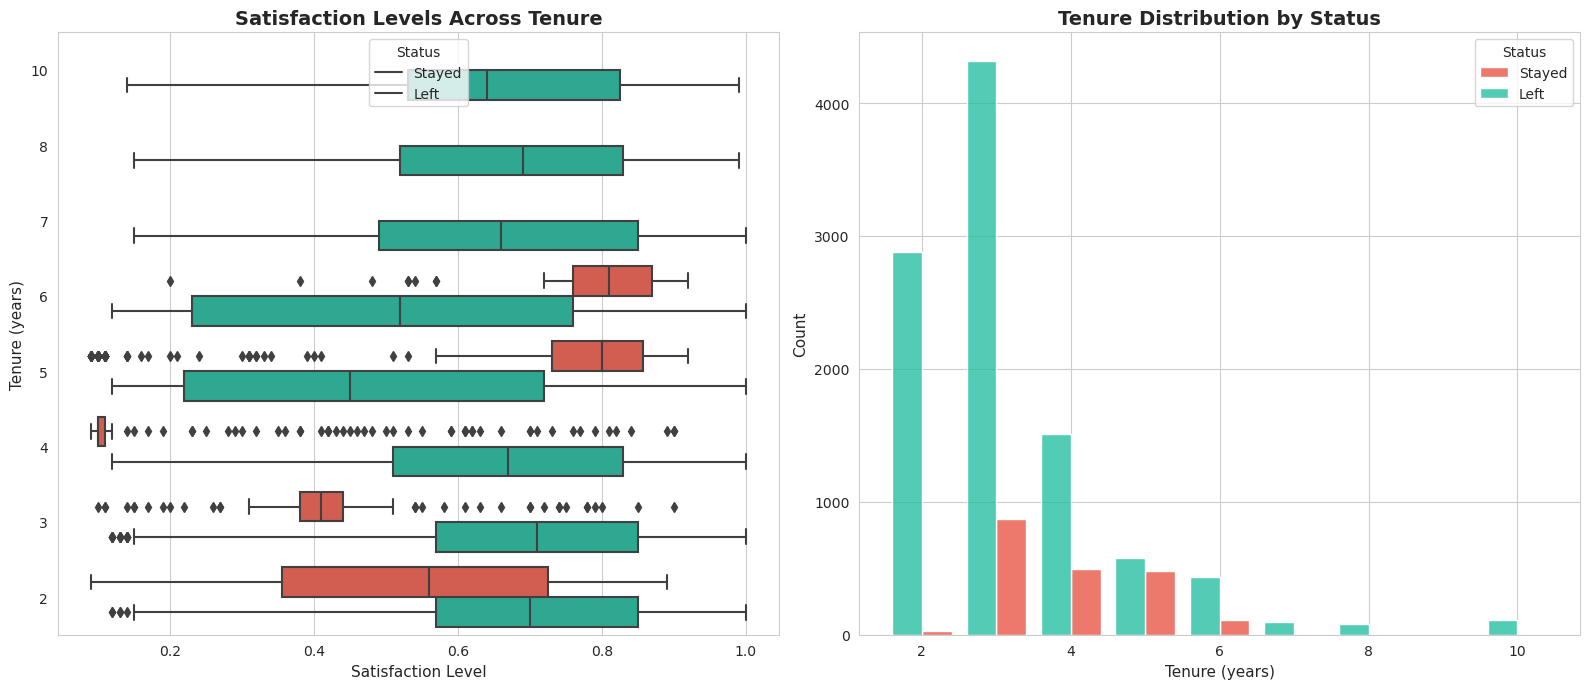

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.boxplot(
    data=df_clean,
    x='satisfaction_level',
    y='tenure',
    hue='left',
    orient='h',
    ax=axes[0],
    palette=['#1abc9c', '#e74c3c']
)
axes[0].invert_yaxis()
axes[0].set_title('Satisfaction Levels Across Tenure', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Satisfaction Level', fontsize=11)
axes[0].set_ylabel('Tenure (years)', fontsize=11)
axes[0].legend(title='Status', labels=['Stayed', 'Left'])

sns.histplot(
    data=df_clean,
    x='tenure',
    hue='left',
    multiple='dodge',
    shrink=0.8,
    ax=axes[1],
    palette=['#1abc9c', '#e74c3c'],
    discrete=True
)
axes[1].set_title('Tenure Distribution by Status', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tenure (years)', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].legend(title='Status', labels=['Stayed', 'Left'])

plt.tight_layout()
plt.show()

- Employees who left fall into two categories: dissatisfied employees with shorter tenures and satisfied employees with medium-length tenures.
- Four-year employees who left seem to have an unusually low satisfaction level. It's worth investigating changes to company policy that might have affected people specifically at the four-year mark, if possible. 
- The longest-tenured employees didn't leave. Their satisfaction levels aligned with those of newer employees who stayed. 
- The histogram shows that there are relatively few longer-tenured employees. It's possible that they're the higher-ranking, higher-paid employees.

In [13]:
satisfaction_stats = df_clean.groupby('left')['satisfaction_level'].agg(['mean', 'median'])
print(satisfaction_stats)

          mean  median
left                  
0     0.667365    0.69
1     0.440271    0.41


Among employees who stayed, the mean satisfaction score appears to be slightly below the median score. This indicates that satisfaction levels among those who stayed might be skewed to the left. 

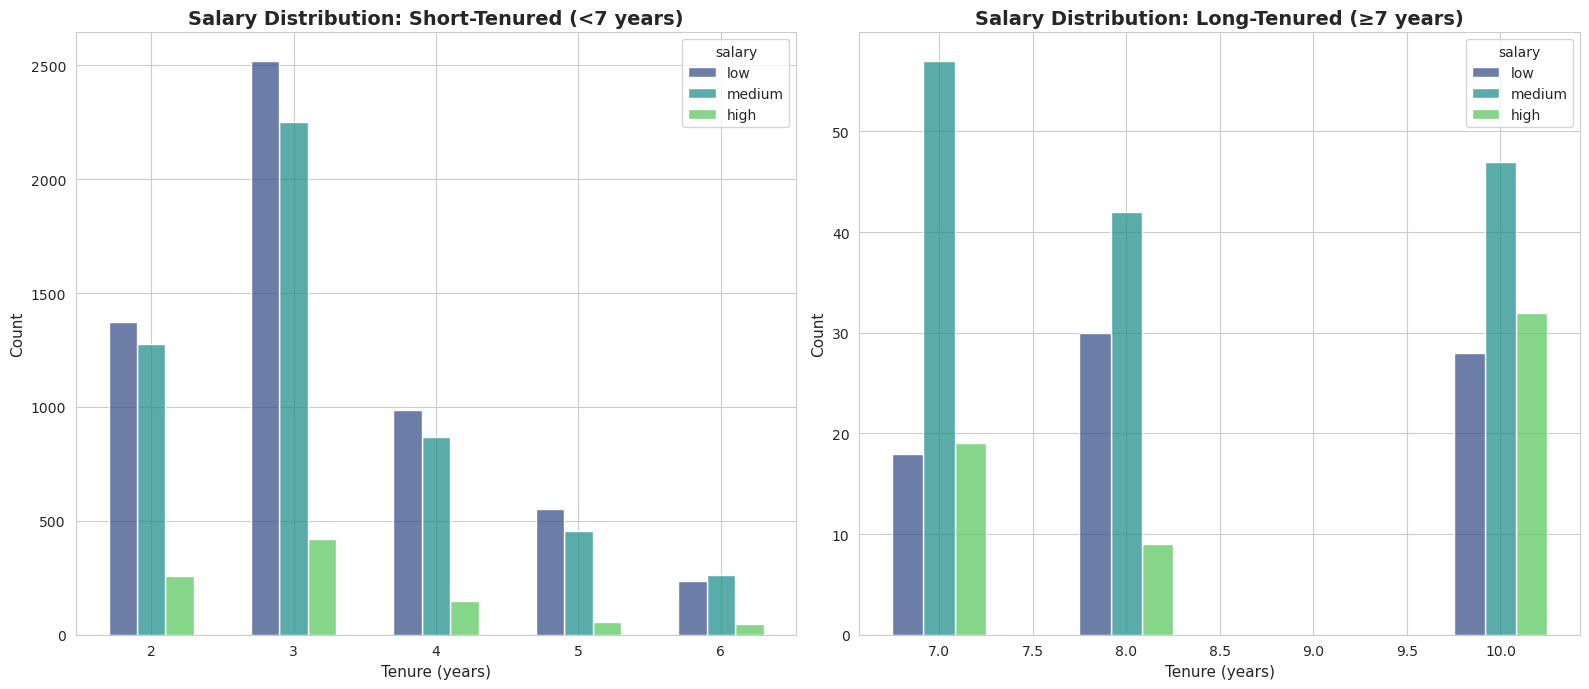

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

short_tenure = df_clean[df_clean['tenure'] < 7]
sns.histplot(
    data=short_tenure,
    x='tenure',
    hue='salary',
    discrete=True,
    hue_order=['low', 'medium', 'high'],
    multiple='dodge',
    shrink=0.6,
    ax=axes[0],
    palette='viridis'
)
axes[0].set_title('Salary Distribution: Short-Tenured (<7 years)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tenure (years)', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)

long_tenure = df_clean[df_clean['tenure'] >= 7]
sns.histplot(
    data=long_tenure,
    x='tenure',
    hue='salary',
    discrete=True,
    hue_order=['low', 'medium', 'high'],
    multiple='dodge',
    shrink=0.5,
    ax=axes[1],
    palette='viridis'
)
axes[1].set_title('Salary Distribution: Long-Tenured (≥7 years)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tenure (years)', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)

plt.tight_layout()
plt.show()

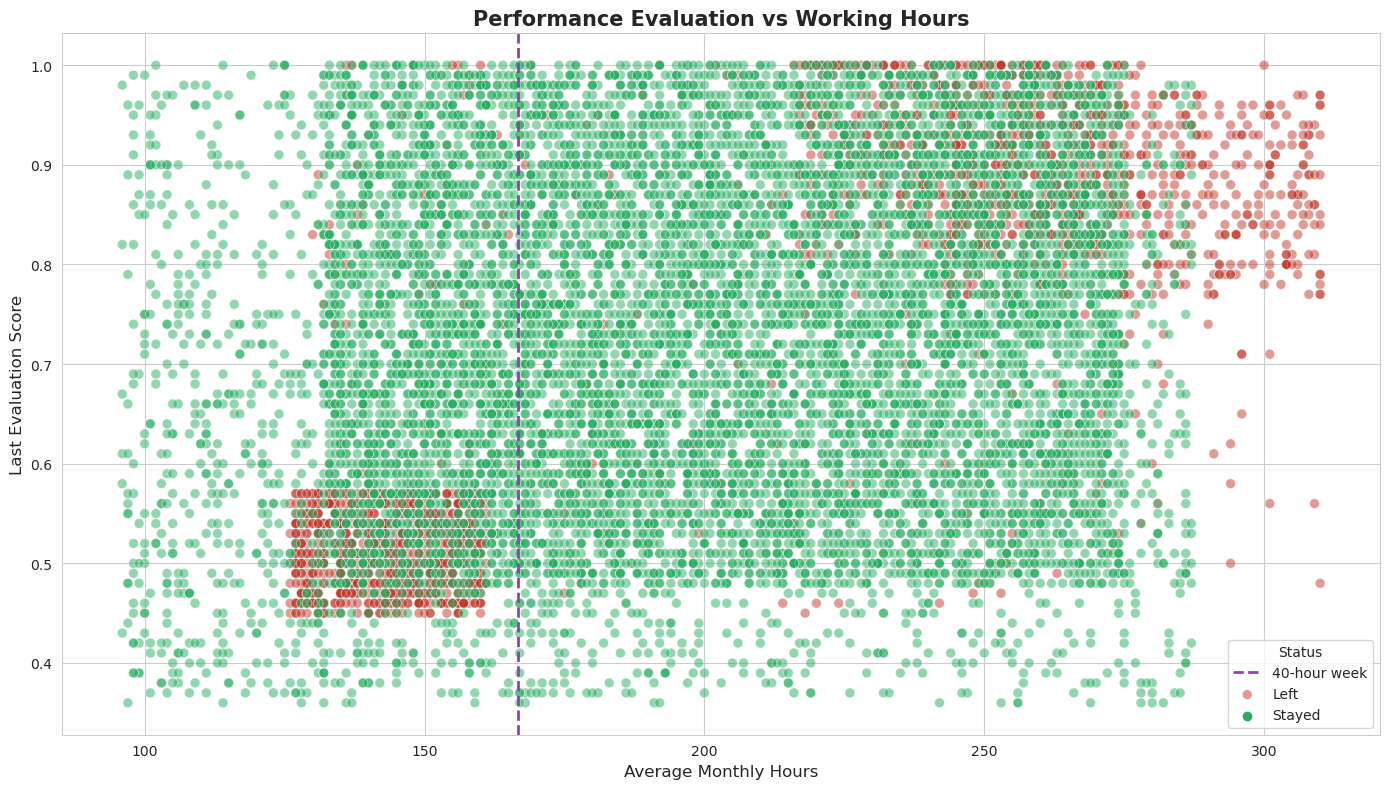

In [15]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.scatterplot(
    data=df_clean,
    x='average_monthly_hours',
    y='last_evaluation',
    hue='left',
    alpha=0.5,
    palette=['#27ae60', '#c0392b'],
    s=50,
    ax=ax
)
ax.axvline(x=166.67, color='#8e44ad', linestyle='--', linewidth=2, label='40-hour week')
ax.set_title('Performance Evaluation vs Working Hours', fontsize=15, fontweight='bold')
ax.set_xlabel('Average Monthly Hours', fontsize=12)
ax.set_ylabel('Last Evaluation Score', fontsize=12)
ax.legend(title='Status', labels=['40-hour week', 'Left', 'Stayed'])
plt.tight_layout()
plt.show()

- The scatterplot indicates two groups of employees who left: overworked employees who performed very well and employees who worked slightly under the nominal monthly average of 166.67 hours with lower evaluation scores. 
- There seems to be a correlation between hours worked and evaluation score. 
- There isn't a high percentage of employees in the upper left quadrant of this plot; but working long hours doesn't guarantee a good evaluation score.
- Most of the employees in this company work well over 167 hours per month.

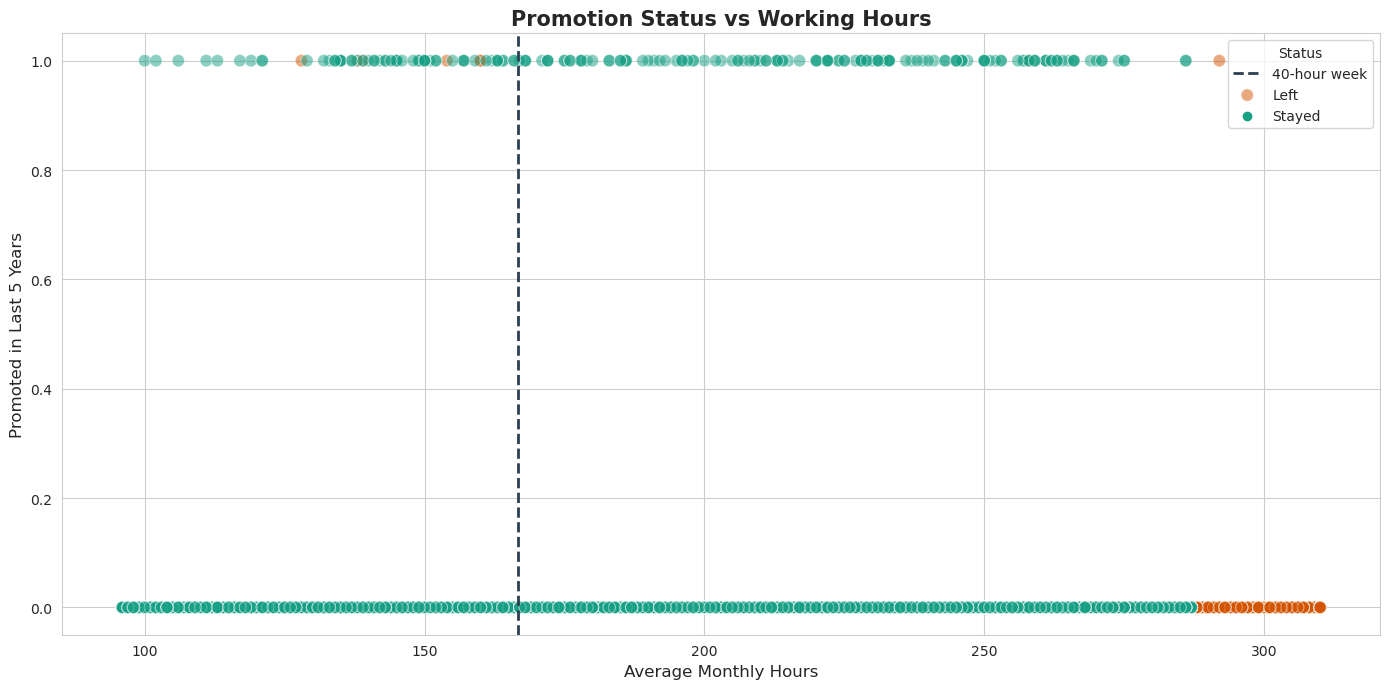

In [16]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.scatterplot(
    data=df_clean,
    x='average_monthly_hours',
    y='promotion_last_5years',
    hue='left',
    alpha=0.5,
    palette=['#16a085', '#d35400'],
    s=80,
    ax=ax
)
ax.axvline(x=166.67, color='#2c3e50', linestyle='--', linewidth=2, label='40-hour week')
ax.set_title('Promotion Status vs Working Hours', fontsize=15, fontweight='bold')
ax.set_xlabel('Average Monthly Hours', fontsize=12)
ax.set_ylabel('Promoted in Last 5 Years', fontsize=12)
ax.legend(title='Status', labels=['40-hour week', 'Left', 'Stayed'])
plt.tight_layout()
plt.show()

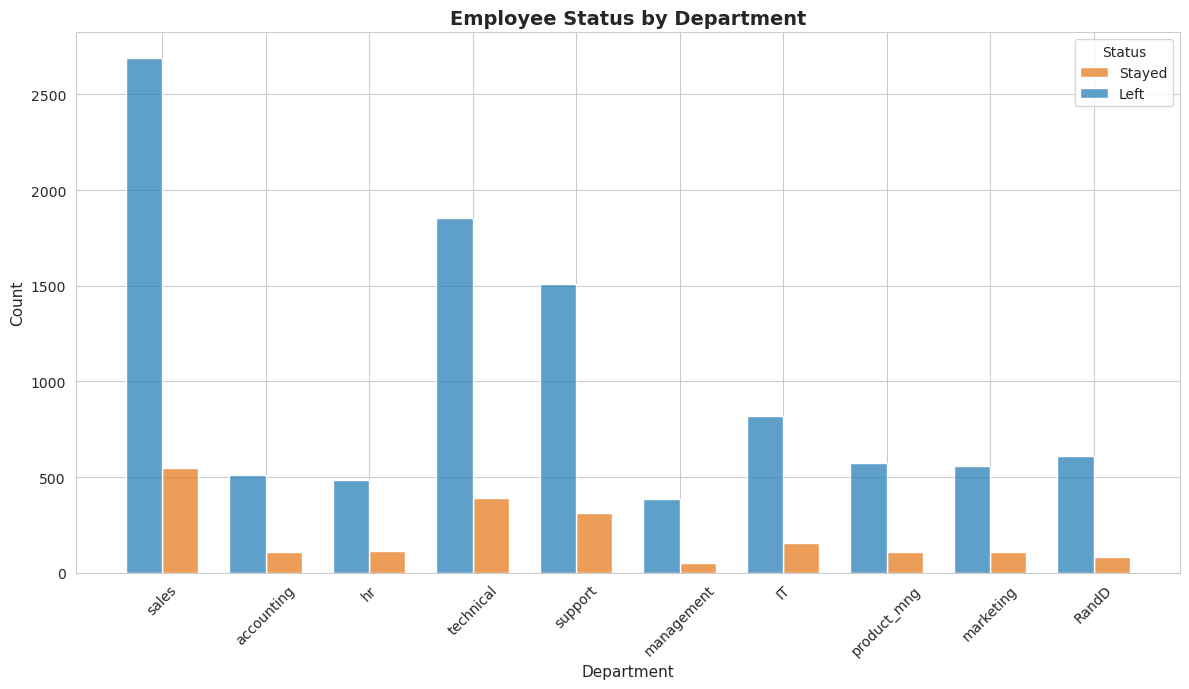

In [17]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.histplot(
    data=df_clean,
    x='department',
    hue='left',
    discrete=True,
    multiple='dodge',
    shrink=0.7,
    ax=ax,
    palette=['#2980b9', '#e67e22']
)
ax.set_title('Employee Status by Department', fontsize=14, fontweight='bold')
ax.set_xlabel('Department', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Status', labels=['Stayed', 'Left'])
plt.tight_layout()
plt.show()

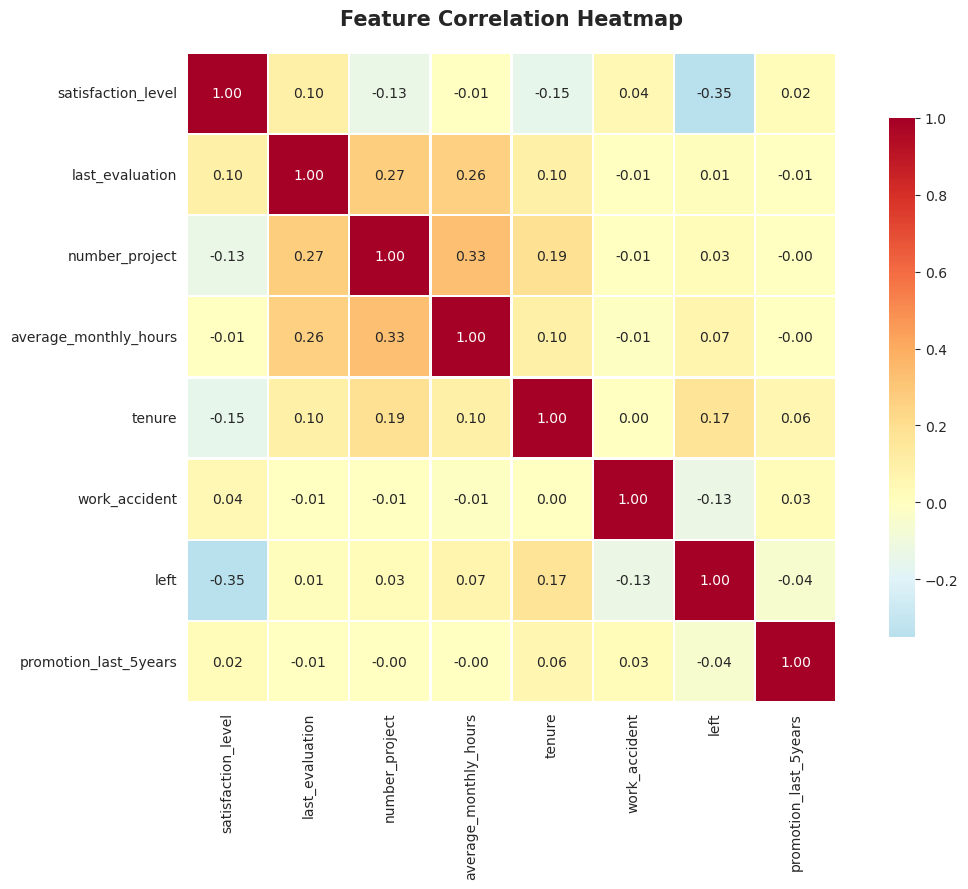

In [18]:
fig, ax = plt.subplots(figsize=(12, 9))
correlation_matrix = df_clean.select_dtypes(include=[np.number]).corr()
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdYlBu_r',
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={'shrink': 0.8},
    ax=ax
)
ax.set_title('Feature Correlation Heatmap', fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### Insights

It appears that employees are leaving the company as a result of poor management. Leaving is tied to longer working hours, many projects, and generally lower satisfaction levels. It can be ungratifying to work long hours and not receive promotions or good evaluation scores. There's a sizeable group of employees at this company who are probably burned out. It also appears that if an employee has spent more than six years at the company, they tend not to leave. 

## Step 2. Feature Engineering and Modeling

### Modeling Approach A: Logistic Regression Model

In [19]:
df_encoded = df_clean.copy()

df_encoded['salary'] = (
    df_encoded['salary']
    .astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

df_encoded = pd.get_dummies(df_encoded, columns=['department'], drop_first=False)

print(f"  Original shape: {df_clean.shape}")
print(f"  Encoded shape: {df_encoded.shape}")
print(f"  New columns added: {df_encoded.shape[1] - df_clean.shape[1]}")

  Original shape: (11991, 10)
  Encoded shape: (11991, 19)
  New columns added: 9


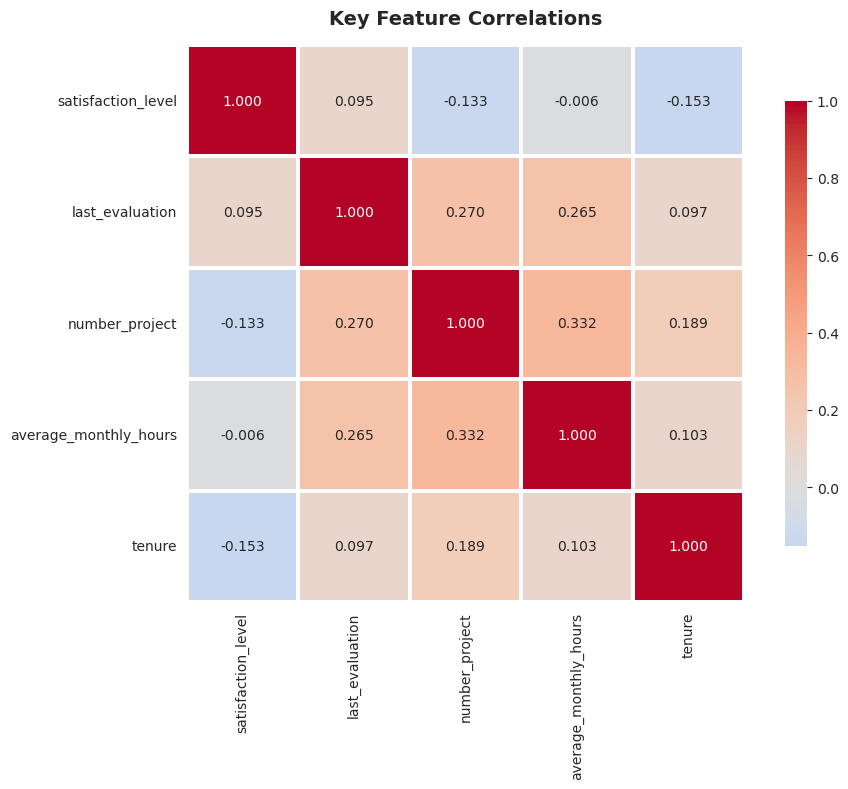

In [20]:
key_features = ['satisfaction_level', 'last_evaluation', 'number_project',
                'average_monthly_hours', 'tenure']

fig, ax = plt.subplots(figsize=(10, 8))
correlation_subset = df_encoded[key_features].corr()
sns.heatmap(
    correlation_subset,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=2,
    cbar_kws={'shrink': 0.8},
    ax=ax
)
ax.set_title('Key Feature Correlations', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

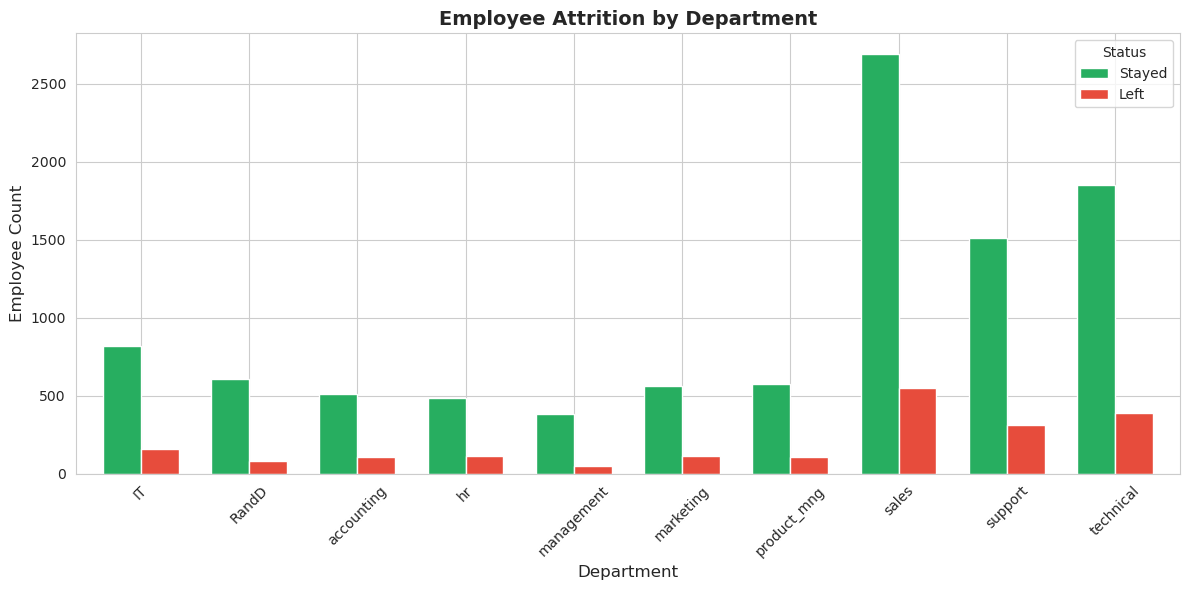

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
department_counts = pd.crosstab(df_clean['department'], df_clean['left'])
department_counts.plot(
    kind='bar',
    color=['#27ae60', '#e74c3c'],
    ax=ax,
    width=0.7
)
ax.set_title('Employee Attrition by Department', fontsize=14, fontweight='bold')
ax.set_xlabel('Department', fontsize=12)
ax.set_ylabel('Employee Count', fontsize=12)
ax.legend(title='Status', labels=['Stayed', 'Left'], loc='upper right')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [22]:
df_logreg = df_encoded[
    (df_encoded['tenure'] >= lower_bound) &
    (df_encoded['tenure'] <= upper_bound)
].copy()

print(f"  Original dataset: {len(df_encoded):,} rows")
print(f"  After outlier removal: {len(df_logreg):,} rows")
print(f"  Removed: {len(df_encoded) - len(df_logreg):,} outliers")

  Original dataset: 11,991 rows
  After outlier removal: 11,167 rows
  Removed: 824 outliers


In [23]:
y_logreg = df_logreg['left']
X_logreg = df_logreg.drop('left', axis=1)

print(f"\n  Features shape: {X_logreg.shape}")
print(f"  Target shape: {y_logreg.shape}")

print("\n  Class distribution:")
print(y_logreg.value_counts(normalize=True))


  Features shape: (11167, 18)
  Target shape: (11167,)

  Class distribution:
0    0.831468
1    0.168532
Name: left, dtype: float64


In [24]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_logreg, y_logreg,
    test_size=0.25,
    stratify=y_logreg,
    random_state=42
)

print(f"\n  Training set: {len(X_train_lr):,} samples")
print(f"  Test set: {len(X_test_lr):,} samples")


  Training set: 8,375 samples
  Test set: 2,792 samples


In [25]:
scaler = StandardScaler()
X_train_lr_scaled = scaler.fit_transform(X_train_lr)
X_test_lr_scaled = scaler.transform(X_test_lr)

In [26]:
log_model = LogisticRegression(random_state=42, max_iter=500, solver='lbfgs')
log_model.fit(X_train_lr_scaled, y_train_lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
y_pred_lr = log_model.predict(X_test_lr_scaled)

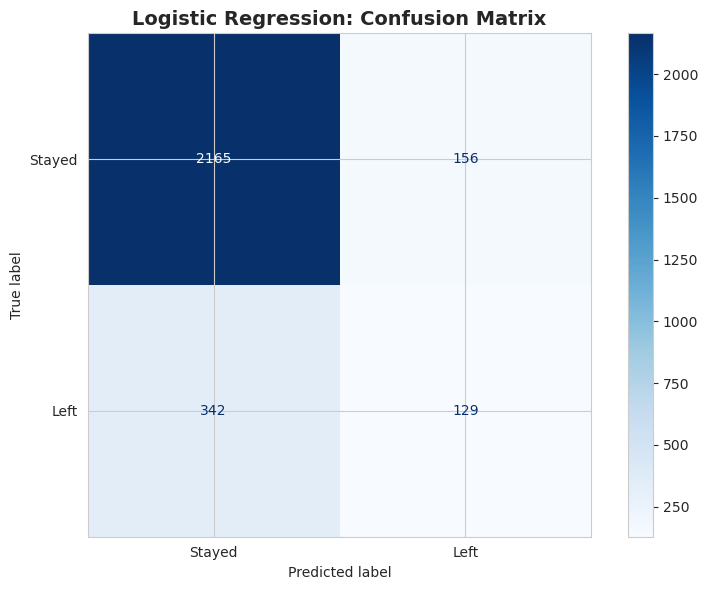

In [28]:
cm_lr = confusion_matrix(y_test_lr, y_pred_lr)

fig, ax = plt.subplots(figsize=(8, 6))
disp_lr = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr,
    display_labels=['Stayed', 'Left']
)
disp_lr.plot(cmap='Blues', values_format='d', ax=ax)
ax.set_title('Logistic Regression: Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [29]:
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test_lr, y_pred_lr, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      2321
    Predicted would leave       0.45      0.27      0.34       471

                 accuracy                           0.82      2792
                macro avg       0.66      0.60      0.62      2792
             weighted avg       0.79      0.82      0.80      2792



### Modeling Approach B: Tree-based Model

In [30]:
y = df_encoded['left']
X = df_encoded.drop('left', axis=1)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=0
)

print(f"  Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Test set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\n  Class distribution in training set:")
print(y_train.value_counts(normalize=True))

  Training set: 8,993 samples (75.0%)
  Test set: 2,998 samples (25.0%)

  Class distribution in training set:
0    0.833982
1    0.166018
Name: left, dtype: float64


#### Decision tree - Round 1

In [32]:
tree = DecisionTreeClassifier(random_state=0)

cv_params = {
    'max_depth': [4, 6, 8, None],
    'min_samples_leaf': [2, 5, 1],
    'min_samples_split': [2, 4, 6]
}

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

tree1.fit(X_train, y_train)
print("✓ Training complete")

print(f"\nBest parameters: {tree1.best_params_}")
print(f"Best score: {tree1.best_score_:.6f}")

✓ Training complete

Best parameters: {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best score: 0.969819


In [33]:
rf_params = {
    'max_depth': [3, 5, None],
    'max_features': [1.0],
    'max_samples': [0.7, 1.0],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [300, 500]
}

In [34]:
rf_model_1 = RandomForestClassifier(random_state=0)
rf1 = GridSearchCV(
    estimator=rf_model_1,
    param_grid=rf_params,
    scoring=scoring,
    cv=4,
    refit='roc_auc',
    n_jobs=-1,
    verbose=0
)
rf1.fit(X_train, y_train)
print("✓ Training complete")
print(f"\nBest parameters: {rf1.best_params_}")
print(f"Best ROC-AUC score: {rf1.best_score_:.6f}")

✓ Training complete

Best parameters: {'max_depth': 5, 'max_features': 1.0, 'max_samples': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 500}
Best ROC-AUC score: 0.980425


In [35]:
def make_results(model_name, model_object, metric='auc'):
    """
    Extract CV results from GridSearchCV.
    
    Parameters:
    - model_name: Name of the model
    - model_object: Fitted GridSearchCV object
    - metric: Metric to use ('auc', 'precision', 'recall', 'f1', 'accuracy')
    
    Returns: DataFrame with all scores
    """
    metric_map = {
        'auc': 'mean_test_roc_auc',
        'precision': 'mean_test_precision',
        'recall': 'mean_test_recall',
        'f1': 'mean_test_f1',
        'accuracy': 'mean_test_accuracy'
    }
    
    cv_results = pd.DataFrame(model_object.cv_results_)
    best_idx = cv_results[metric_map[metric]].idxmax()
    best = cv_results.iloc[best_idx]
    
    return pd.DataFrame({
        'model': [model_name],
        'precision': [best['mean_test_precision']],
        'recall': [best['mean_test_recall']],
        'F1': [best['mean_test_f1']],
        'accuracy': [best['mean_test_accuracy']],
        'auc': [best['mean_test_roc_auc']]
    })


def get_scores(model_name, model, X_test_data, y_test_data):
    """
    Get test set scores.
    
    Parameters:
    - model_name: Name of the model
    - model: Fitted GridSearchCV object
    - X_test_data: Test features
    - y_test_data: Test labels
    
    Returns: DataFrame with test scores
    """
    preds = model.best_estimator_.predict(X_test_data)
    
    return pd.DataFrame({
        'model': [model_name],
        'precision': [precision_score(y_test_data, preds)],
        'recall': [recall_score(y_test_data, preds)],
        'f1': [f1_score(y_test_data, preds)],
        'accuracy': [accuracy_score(y_test_data, preds)],
        'AUC': [roc_auc_score(y_test_data, preds)]
    })

#### Random forest - Round 1

In [36]:
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
rf1_cv_results = make_results('random forest cv', rf1, 'auc')

print(tree1_cv_results)
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.914552  0.916949  0.915707  0.971978  0.969819
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.950023  0.915614  0.932467  0.977983  0.980425


In [37]:
rf1_test_scores = get_scores('random forest1 test', rf1, X_test, y_test)
print(rf1_test_scores)

                 model  precision    recall        f1  accuracy       AUC
0  random forest1 test   0.964211  0.919679  0.941418  0.980987  0.956439


#### Feature Engineering

To address potential data leakage and build a more realistic model, I am dropping `satisfaction_level` and creating a new overworked binary feature.

In [39]:
df2 = df_encoded.drop('satisfaction_level', axis=1)

In [40]:
df2['overworked'] = df2['average_monthly_hours']
print(f"Max hours: {df2['overworked'].max()}")
print(f"Min hours: {df2['overworked'].min()}")

Max hours: 310
Min hours: 96


166.67 is approximately the average number of monthly hours for someone who works 50 weeks per year, 5 days per week, 8 hours per day. 

You could define being overworked as working more than 175 hours per month on average.

To make the `overworked` column binary, you could reassign the column using a boolean mask.
- `df3['overworked'] > 175` creates a series of booleans, consisting of `True` for every value > 175 and `False` for every values ≤ 175
- `.astype(int)` converts all `True` to `1` and all `False` to `0` 

In [41]:
df2['overworked'] = (df2['overworked'] > 175).astype(int)
print(f"\nOverworked distribution:")
print(df2['overworked'].value_counts())


Overworked distribution:
1    7630
0    4361
Name: overworked, dtype: int64


In [42]:
df2 = df2.drop('average_monthly_hours', axis=1)
print(f"\nNew dataset shape: {df2.shape}")
print(df2.head())


New dataset shape: (11991, 18)
   last_evaluation  number_project  tenure  work_accident  left  \
0             0.53               2       3              0     1   
1             0.86               5       6              0     1   
2             0.88               7       4              0     1   
3             0.87               5       5              0     1   
4             0.52               2       3              0     1   

   promotion_last_5years  salary  department_IT  department_RandD  \
0                      0       0              0                 0   
1                      0       1              0                 0   
2                      0       1              0                 0   
3                      0       0              0                 0   
4                      0       0              0                 0   

   department_accounting  department_hr  department_management  \
0                      0              0                      0   
1                 

In [43]:
y = df2['left']
X = df2.drop('left', axis=1)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=0)

print(f"Training: {len(X_train)}, Testing: {len(X_test)}")

Training: 8993, Testing: 2998


#### Decision tree - Round 2

In [45]:
tree = DecisionTreeClassifier(random_state=0)
cv_params = {
    'max_depth': [4, 6, 8, None],
    'min_samples_leaf': [2, 5, 1],
    'min_samples_split': [2, 4, 6]
}
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

tree2 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [46]:
tree2.fit(X_train, y_train)
print("✓ Training complete")

print(f"\nBest parameters: {tree2.best_params_}")
print(f"Best score: {tree2.best_score_:.6f}")

✓ Training complete

Best parameters: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}
Best score: 0.958675


#### Random forest - Round 2

In [47]:
rf = RandomForestClassifier(random_state=0)
cv_params = {
    'max_depth': [3, 5, None],
    'max_features': [1.0],
    'max_samples': [0.7, 1.0],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [300, 500]
}

rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [48]:
rf2.fit(X_train, y_train)
print("✓ Training complete")

print(f"\nBest parameters: {rf2.best_params_}")
print(f"Best score: {rf2.best_score_:.6f}")

✓ Training complete

Best parameters: {'max_depth': 5, 'max_features': 1.0, 'max_samples': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best score: 0.964810


In [49]:
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')

print("\nCross-Validation Results:")
print(tree2_cv_results)
print(rf2_cv_results)


Cross-Validation Results:
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.958675
               model  precision    recall        F1  accuracy      auc
0  random forest2 cv   0.866758  0.878754  0.872407  0.957411  0.96481


In [50]:
rf2_test_scores = get_scores('random forest2 test', rf2, X_test, y_test)
print("\nRandom Forest Test Set Results:")
print(rf2_test_scores)


Random Forest Test Set Results:
                 model  precision    recall      f1  accuracy       AUC
0  random forest2 test   0.870406  0.903614  0.8867  0.961641  0.938407


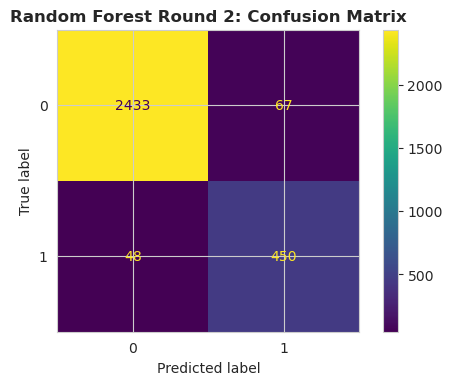

In [51]:
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rf2.classes_)
disp.plot(values_format='')
plt.title('Random Forest Round 2: Confusion Matrix', fontsize=12, fontweight='bold')
plt.show()

The model predicts more false positives than false negatives, which means that some employees may be identified as at risk of quitting or getting fired, when that's actually not the case.  To understand what factors the model considers 'at-risk,' I will now inspect the feature importances.

## Step 3. Evaluation and Interpretation

### Decision tree splits

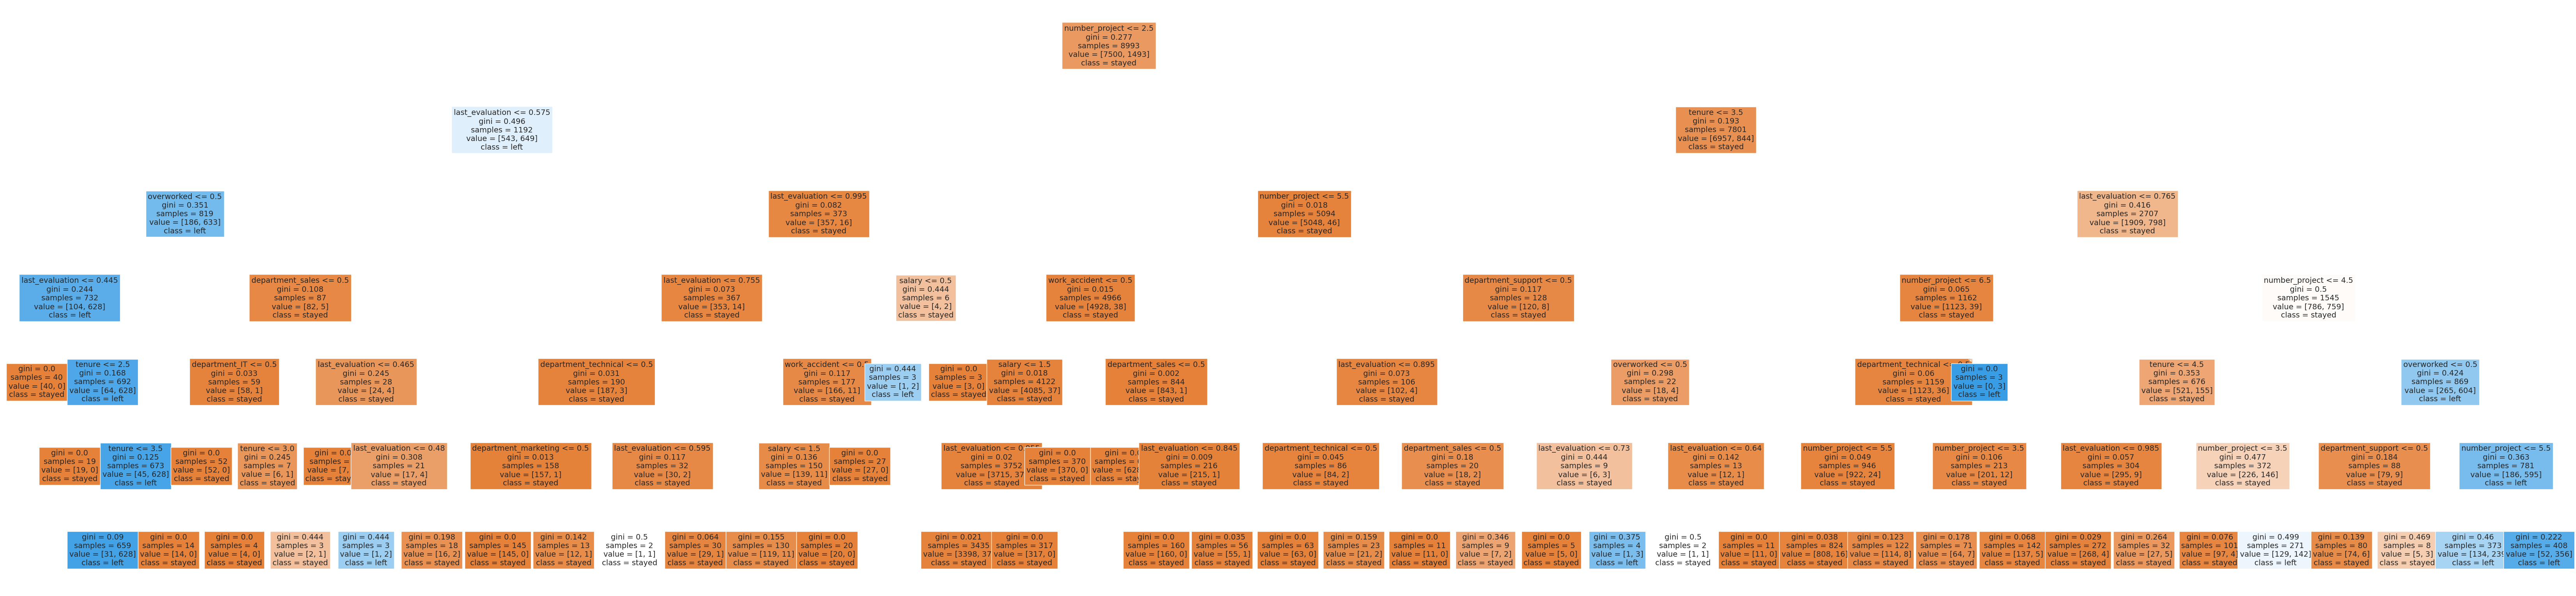

In [52]:
plt.figure(figsize=(85, 20))
plot_tree(tree2.best_estimator_, max_depth=6, fontsize=14,
          feature_names=X.columns,
          class_names={0: 'stayed', 1: 'left'}, filled=True)
plt.show()

### Decision tree feature importance

In [53]:
tree2_importances = pd.DataFrame(
    tree2.best_estimator_.feature_importances_,
    columns=['gini_importance'],
    index=X.columns
)
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
print(tree2_importances)

                      gini_importance
last_evaluation              0.343958
number_project               0.343385
tenure                       0.215681
overworked                   0.093498
department_support           0.001142
salary                       0.000910
department_sales             0.000607
department_technical         0.000418
work_accident                0.000183
department_IT                0.000139
department_marketing         0.000078


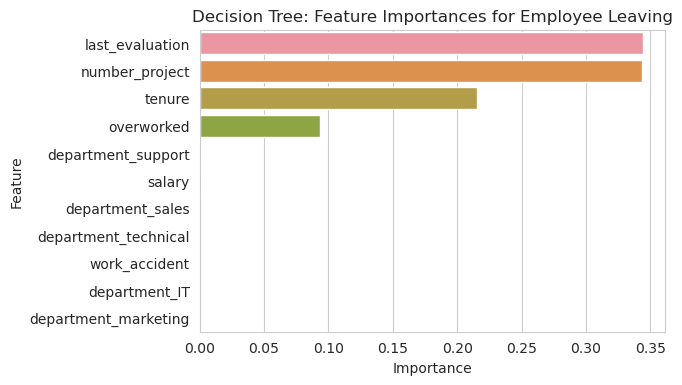

In [54]:
sns.barplot(data=tree2_importances, x='gini_importance', 
            y=tree2_importances.index, orient='h')
plt.title('Decision Tree: Feature Importances for Employee Leaving', fontsize=12)
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

### Random forest feature importance

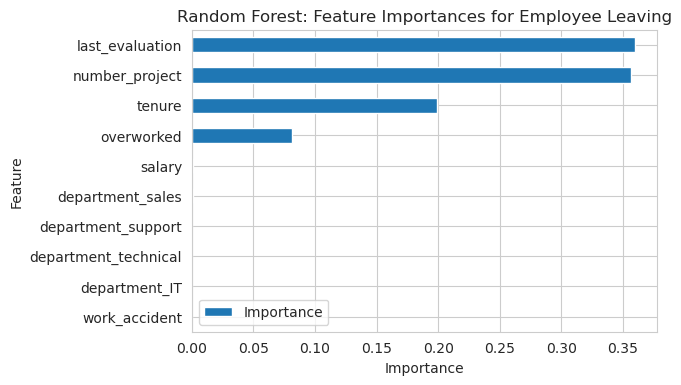

In [55]:
feat_impt = rf2.best_estimator_.feature_importances_
ind = np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]
feat = X.columns[ind]
feat_impt = feat_impt[ind]
y_df = pd.DataFrame({'Feature': feat, 'Importance': feat_impt})
y_sort_df = y_df.sort_values('Importance')

fig = plt.figure()
ax1 = fig.add_subplot(111)
y_sort_df.plot(kind='barh', ax=ax1, x='Feature', y='Importance')
ax1.set_title('Random Forest: Feature Importances for Employee Leaving', fontsize=12)
ax1.set_ylabel('Feature')
ax1.set_xlabel('Importance')
plt.show()

### Saving Models

In [56]:
def write_pickle(path, model_object, save_as):
    """Save model as pickle file"""
    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)
    print(f"✓ Saved: {save_as}.pickle")

def read_pickle(path, saved_model_name):
    """Load model from pickle file"""
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)
    return model

In [57]:
path = './'

In [58]:
write_pickle(path, rf1, 'hr_rf1')
write_pickle(path, rf2, 'hr_rf2')
write_pickle(path, tree1, 'hr_tree1')
write_pickle(path, tree2, 'hr_tree2')

print("\n✅ All models saved successfully!")

✓ Saved: hr_rf1.pickle
✓ Saved: hr_rf2.pickle
✓ Saved: hr_tree1.pickle
✓ Saved: hr_tree2.pickle

✅ All models saved successfully!


## Step 4. Conclusion and Future improvements

### Conclusion

In exploring the employee data in Step 1, it became clear that any predictive model would need to account for potential data leakage to be viable in a real-world HR setting. The feature engineering in Step 2—specifically dropping `satisfaction_level` and creating the `overworked` feature—was crucial for building a robust model. The final Random Forest Classifier, chosen after hyperparameter tuning, proved highly effective, correctly predicting 96% of outcomes on the test set. More importantly for the business goal, it achieved a recall of 90% for employees who left, ensuring most at-risk individuals are identified.

The model's primary errors are false positives, meaning it is more likely to flag a safe employee as "at-risk" than to miss one who is about to leave. For a retention strategy, this is a desirable trade-off, as the cost of losing an employee is far greater than the minor operational cost of an unnecessary manager check-in.

### Future Work & Areas for Improvement

From here, I see two main areas for improving upon this stronger baseline model:

1. The model performed well despite the ~17% churn rate, but the 48 false negatives show there is still room for improvement. I would implement a minority over-sampling technique like SMOTE on the training data to create a more balanced dataset. This could train the model to be even more sensitive to the patterns of employees who leave, potentially catching those last few high-risk cases.

2. The current model relies heavily on a few key features. Its accuracy could be significantly enhanced by incorporating more granular HR data. I would prioritize adding:
- Time since last promotion: This is likely a much stronger predictor than the current binary promotion_last_5years feature.
- Compensation Ratio (Compa-Ratio): Instead of categorical salary, using a metric that compares an employee's salary to the market average for their role would provide a much richer signal.
- Manager performance/turnover: Adding data about an employee's direct manager could uncover departmental or team-specific issues driving churn.